<a href="https://colab.research.google.com/github/bandot33th/CapstoneProject/blob/main/Capstone_I_Waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import zipfile
import os

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.14.0
• Using TensorFlow Hub Version:  0.15.0
• GPU Device Found.


In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [4]:
# Dataset Path from Shared GDrive
data_path = "/content/drive/Shareddrives/Dataset/BN_Material.zip"
test_path = "/content/drive/Shareddrives/Dataset/BN_Test.zip"

In [5]:
# Extract Dataset
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [6]:
# Extract Test Set
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [7]:
# Create Train, Validation, and Test Path. Also Define The Classes
train_dir = "/content/dataset/BN_Material/TRAIN"
val_dir  = "/content/dataset/BN_Material/VAL"
test_dir  = "/content/dataset/TEST"

classes = ['B', 'N']

In [8]:
# Resize Image Function using Tensorflow ImageGenerator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode = 'nearest')

validation_datagen  = ImageDataGenerator(
                    rescale=1./255)

test_datagen  = ImageDataGenerator(
                    rescale=1./255)

In [9]:
# Resize and Batch Train and Validation Image using ImageGen
train_generator = train_datagen.flow_from_directory(
        train_dir,                # Direktori data latih
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        batch_size=32,
        classes = ['B', 'N'],
        class_mode='binary')      # Klasifikasi 2 kelas lebih menggunakan mode = categorical

validation_generator = validation_datagen.flow_from_directory(
        val_dir,                  # Direktori data validasi
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        batch_size=32,
        classes = ['B', 'N'],
        class_mode='binary')      # Klasifikasi 2 kelas lebih menggunakan mode = categorical

test_generator = test_datagen.flow_from_directory(
        test_dir,                  # Direktori data test
        target_size= IMAGE_SIZE,   # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
        shuffle = False,
        batch_size=1,
        classes = ['B', 'N'],
        class_mode='binary')

Found 239690 images belonging to 2 classes.
Found 16726 images belonging to 2 classes.
Found 16726 images belonging to 2 classes.


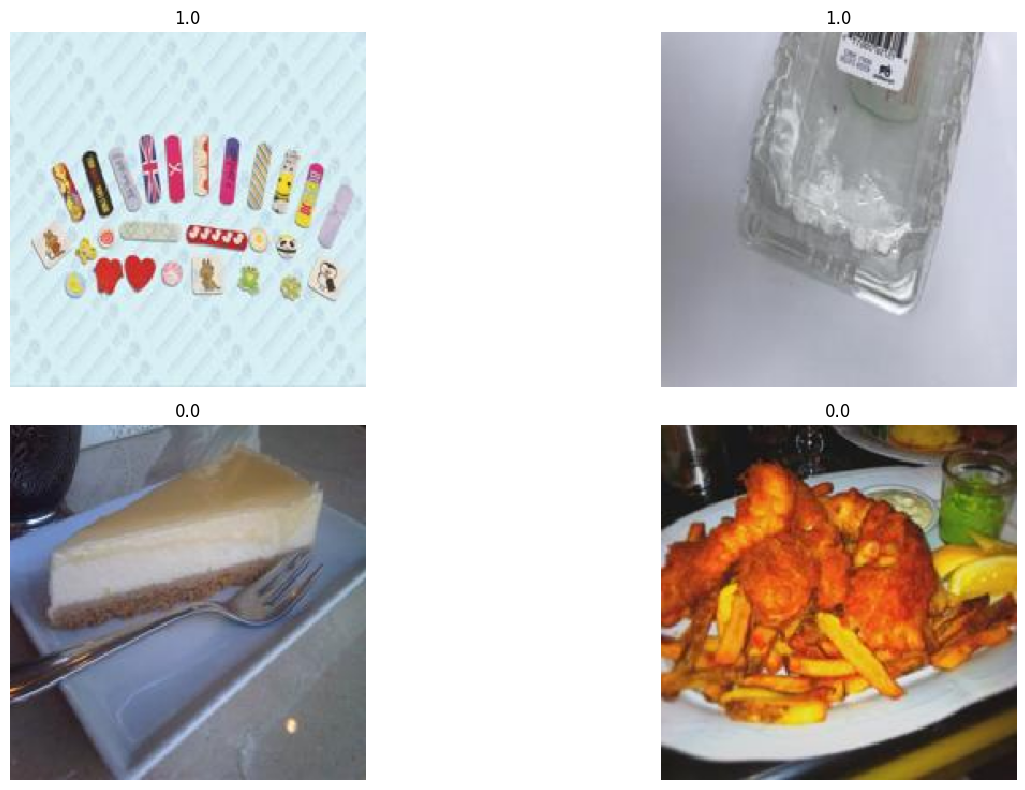

In [10]:
import matplotlib.pyplot as plt

# Memuat satu batch data gambar dari generator
images, labels = next(train_generator)

# Menampilkan gambar dengan visualisasi augmentasi
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(labels[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Extract Layer from MobileNet Module
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable= True)

In [12]:
# Model Build
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [13]:
# Model Compile
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [14]:
# Training The Model
history = model.fit(
      train_generator,
      steps_per_epoch=25,                         # Berapa batch yang akan dieksekusi pada setiap epoch
      epochs=5,
      validation_data = validation_generator,     # Menampilkan akurasi pengujian data validasi
      validation_steps=5,                         # Berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/5
25/25 - 36s - loss: 0.3058 - accuracy: 0.9200 - val_loss: 0.3535 - val_accuracy: 0.8938 - 36s/epoch - 1s/step
Epoch 2/5
25/25 - 4s - loss: 0.2327 - accuracy: 0.9463 - val_loss: 0.2470 - val_accuracy: 0.9250 - 4s/epoch - 161ms/step
Epoch 3/5
25/25 - 4s - loss: 0.2396 - accuracy: 0.9413 - val_loss: 0.3366 - val_accuracy: 0.8875 - 4s/epoch - 161ms/step
Epoch 4/5
25/25 - 4s - loss: 0.1936 - accuracy: 0.9650 - val_loss: 0.3928 - val_accuracy: 0.8875 - 4s/epoch - 164ms/step
Epoch 5/5
25/25 - 4s - loss: 0.1846 - accuracy: 0.9712 - val_loss: 0.3626 - val_accuracy: 0.9125 - 4s/epoch - 162ms/step


In [15]:
# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

16726/16726 [==============================] - 178s 11ms/step - loss: 0.2860 - accuracy: 0.9350
Test Accuracy: 0.9349515438079834


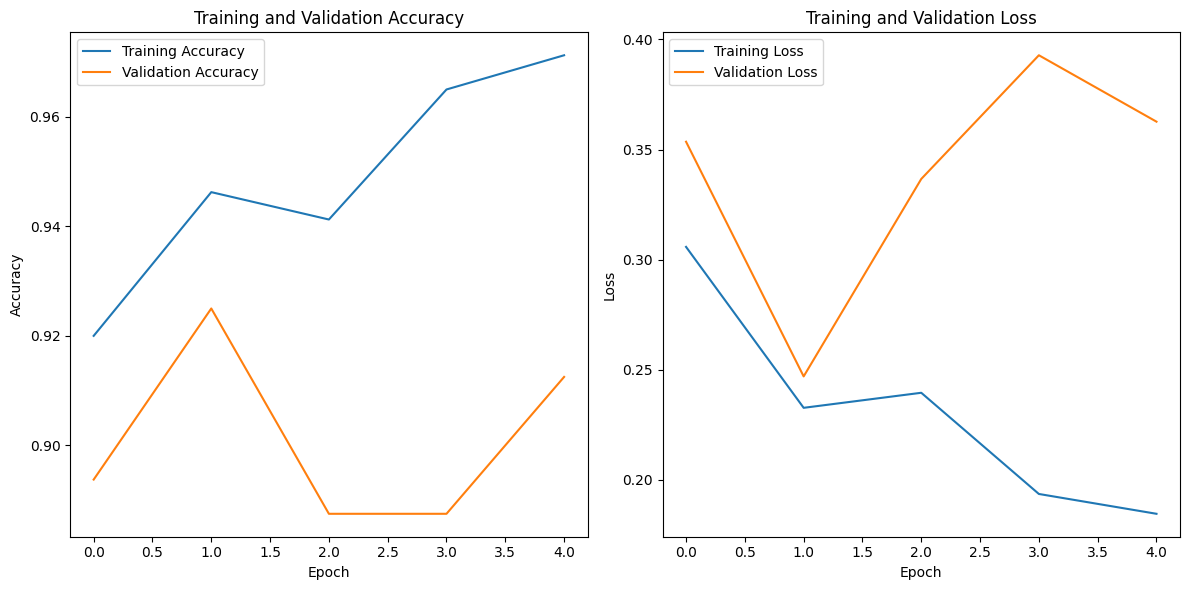

In [16]:
import matplotlib.pyplot as plt

# Mendapatkan data pelatihan
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot akurasi dan loss pelatihan bersebelahan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot akurasi pelatihan dan validasi
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss pelatihan dan validasi
ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

Saving download (1).jpg to download (1).jpg
1/1 [==============================] - 1s 503ms/step
download (1).jpg
Sampah Anorganik


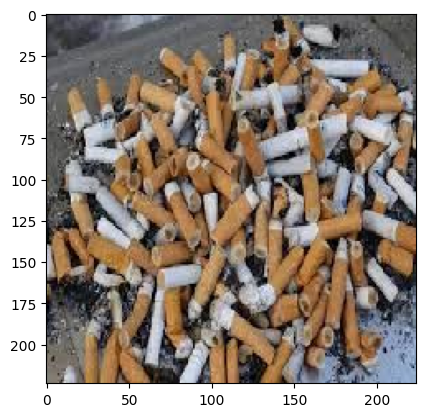

In [17]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size= IMAGE_SIZE)

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  print(fn)
  if classes[0]>0.5:
    print("Sampah Anorganik")
  else:
    print("Sampah Organik")

## Model Export

In [18]:
B_N_SAVED_MODEL = "exp_saved_model"

In [19]:
tf.saved_model.save(model, B_N_SAVED_MODEL)

In [20]:
%%bash -s $B_N_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-12-07 08:08:27.890994: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 08:08:27.891151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 08:08:27.891205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 08:08:30.046859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
loaded = tf.saved_model.load(B_N_SAVED_MODEL)

In [22]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense')}


In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(B_N_SAVED_MODEL)

In [24]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [25]:
def representative_data_gen():
    # You can adjust the number of batches according to your needs
    for _ in range(100):
        input_value, _ = next(test_generator)
        yield [input_value]

converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [26]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>